# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)

smoke_test = "CI" in os.environ

In [7]:
import sys
import pkg_resources
import os

# Print Python version
print("Python version:")
print(sys.version)
print()

# Print installed packages
print("Installed packages:")
installed_packages = pkg_resources.working_set
for package in installed_packages:
    print(f"{package.key}=={package.version}")
print()

# Print environment variables
print("Environment variables:")
for key, value in os.environ.items():
    print(f"{key}: {value}")

Python version:
3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:21:29) [Clang 17.0.6 ]

Installed packages:
markupsafe==3.0.2
pint==0.24.3
pyyaml==6.0.2
sparqlwrapper==2.0.0
send2trash==1.8.3
xlsxwriter==3.2.0
anyio==4.6.2.post1
appdirs==1.4.4
appnope==0.1.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==24.2.0
babel==2.16.0
beautifulsoup4==4.12.3
black==24.10.0
bleach==6.1.0
certifi==2024.8.30
cffi==1.17.1
cftime==1.6.4.post1
chardet==5.2.0
charset-normalizer==3.4.0
chirho==0.2.0
click==8.1.7
cloudpickle==3.1.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
dask==2024.10.0
debugpy==1.8.7
decorator==5.1.1
defusedxml==0.7.1
et-xmlfile==2.0.0
exceptiongroup==1.2.2
executing==2.1.0
fastjsonschema==2.20.0
filelock==3.16.1
flexcache==0.3
flexparser==0.3.1
fonttools==4.54.1
fqdn==1.5.1
fsspec==2024.10.0
h11==0.14.0
httpcore==1.0.6
httpx==0.27.2
idna==3.10
importlib-metadata==8.5.0
iniconfig==2.0.0
ipykernel==6.29

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples =  100

In [5]:
print(dir(pyciemss))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'calibrate', 'compiled_dynamics', 'ensemble', 'ensemble_calibrate', 'ensemble_sample', 'integration_utils', 'interfaces', 'interruptions', 'mira_integration', 'observation', 'optimize', 'ouu', 'pyciemss', 'sample', 'visuals']


## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,persistent_beta_s_param,...,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
1095,6,99,60.0,0.229599,0.617157,0.191903,0.062699,0.028018,2.058447,1.0,...,1.787707e+07,4.108407e+05,5.791131e+05,459000.00,13566.784180,450.831818,4.108407e+05,5.791131e+05,13566.784180,450.831818
1096,7,99,70.0,0.229599,0.617157,0.191903,0.062699,0.028018,2.058447,1.0,...,1.321394e+07,1.717592e+06,2.117867e+06,2226276.25,62076.519531,2284.685303,1.717592e+06,2.117867e+06,62076.519531,2284.685303
1097,8,99,80.0,0.229599,0.617157,0.191903,0.062699,0.028018,2.058447,1.0,...,5.588579e+06,3.430476e+06,2.855268e+06,7294198.50,162960.281250,8549.114258,3.430476e+06,2.855268e+06,162960.281250,8549.114258
1098,9,99,90.0,0.229599,0.617157,0.191903,0.062699,0.028018,2.058447,1.0,...,2.165721e+06,2.503421e+06,1.117806e+06,13355837.00,178451.125000,18808.689453,2.503421e+06,1.117806e+06,178451.125000,18808.689453
1099,10,99,100.0,0.229599,0.617157,0.191903,0.062699,0.028018,2.058447,1.0,...,1.935818e+06,7.572812e+05,1.566208e+05,16374251.00,89612.039062,26457.478516,7.572812e+05,1.566208e+05,89612.039062,26457.478516


Index(['timepoint_id', 'sample_id', 'timepoint_unknown',
       'persistent_beta_c_param', 'persistent_kappa_param',
       'persistent_gamma_param', 'persistent_hosp_param',
       'persistent_death_hosp_param', 'persistent_I0_param',
       'persistent_beta_s_param', 'persistent_k_param', 'persistent_t0_param',
       'persistent_total_population_param', 'persistent_delta_param',
       'persistent_los_param', 'S_state', 'I_state', 'E_state', 'R_state',
       'H_state', 'D_state', 'infected_observable_state',
       'exposed_observable_state', 'hospitalized_observable_state',
       'dead_observable_state'],
      dtype='object')


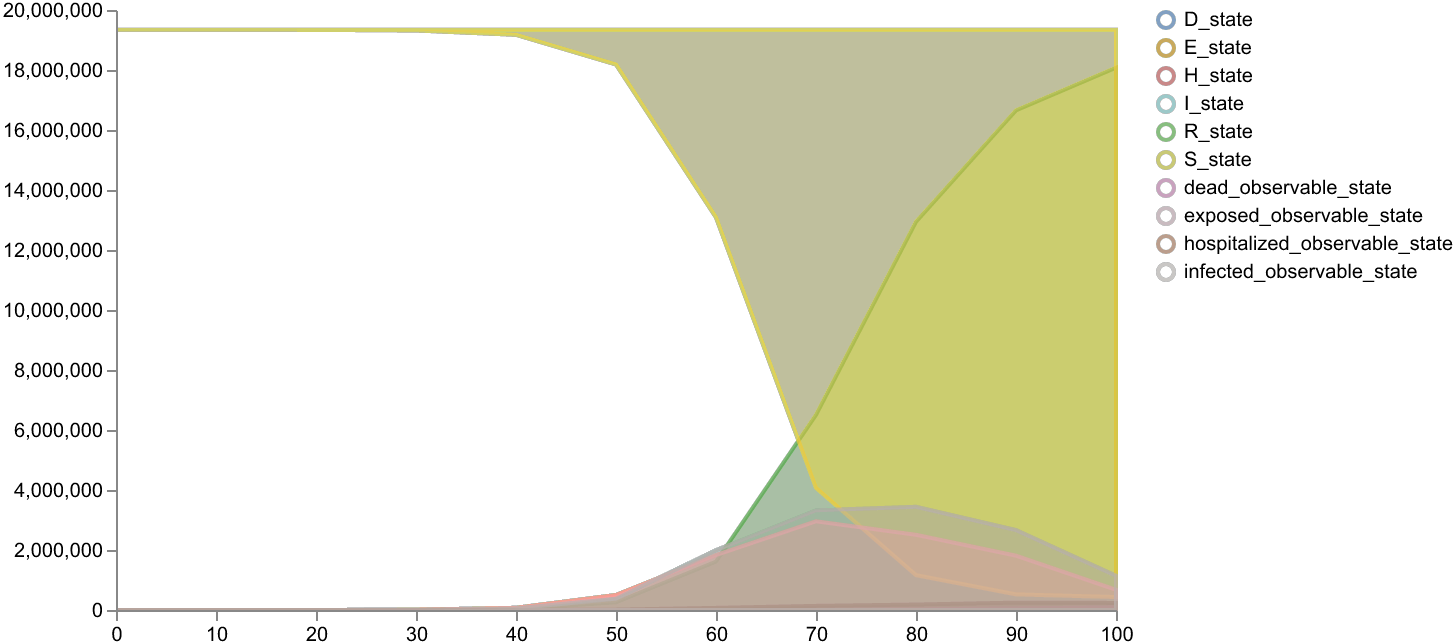

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].tail())
print(result1['data'].columns)
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,persistent_beta_s_param,...,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
105,6,9,60.0,0.219865,0.666137,0.187617,0.069263,0.057367,6.605929,1.0,...,1.527882e+07,1.174690e+06,1.602610e+06,1.239405e+06,41814.554688,2702.749756,1.174690e+06,1.602610e+06,41814.554688,2702.749756
106,7,9,70.0,0.219865,0.666137,0.187617,0.069263,0.057367,6.605929,1.0,...,6.878494e+06,3.489243e+06,3.341233e+06,5.460568e+06,157158.234375,13358.784180,3.489243e+06,3.341233e+06,157158.234375,13358.784180
107,8,9,80.0,0.219865,0.666137,0.187617,0.069263,0.057367,6.605929,1.0,...,1.936077e+06,3.213731e+06,1.653681e+06,1.227556e+07,224037.250000,36960.285156,3.213731e+06,1.653681e+06,224037.250000,36960.285156
108,9,9,90.0,0.219865,0.666137,0.187617,0.069263,0.057367,6.605929,1.0,...,9.350696e+05,1.319130e+06,3.786902e+05,1.651032e+07,138383.500000,58445.421875,1.319130e+06,3.786902e+05,138383.500000,58445.421875
109,10,9,100.0,0.219865,0.666137,0.187617,0.069263,0.057367,6.605929,1.0,...,8.845149e+05,3.275401e+05,4.497160e+04,1.796255e+07,51577.777344,68892.039062,3.275401e+05,4.497160e+04,51577.777344,68892.039062


Index(['timepoint_id', 'sample_id', 'timepoint_unknown',
       'persistent_beta_c_param', 'persistent_kappa_param',
       'persistent_gamma_param', 'persistent_hosp_param',
       'persistent_death_hosp_param', 'persistent_I0_param',
       'persistent_beta_s_param', 'persistent_k_param', 'persistent_t0_param',
       'persistent_total_population_param', 'persistent_delta_param',
       'persistent_los_param', 'S_state', 'I_state', 'E_state', 'R_state',
       'H_state', 'D_state', 'infected_observable_state',
       'exposed_observable_state', 'hospitalized_observable_state',
       'dead_observable_state'],
      dtype='object')


PermutationExplainer explainer: 23it [15:58, 43.55s/it]                        


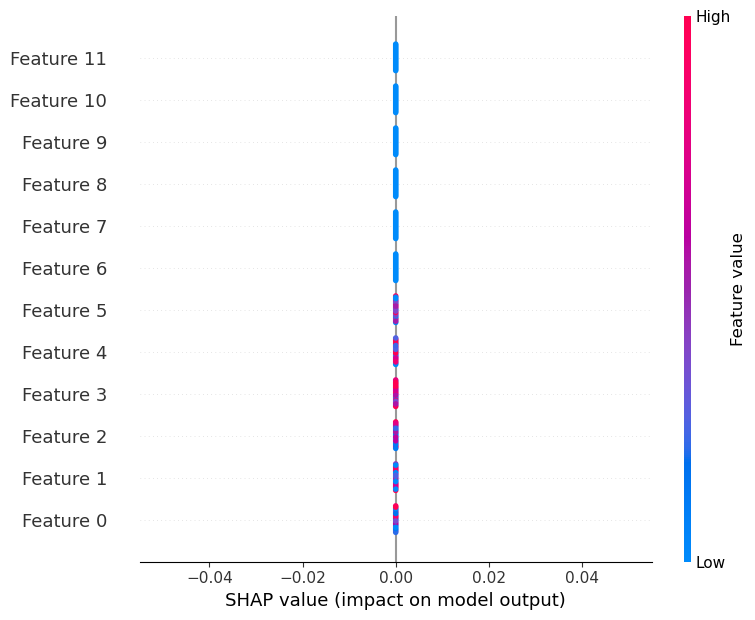

In [38]:
import os
import pyciemss
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 10

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].tail())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Assuming result1 is a pandas DataFrame that contains a 'data' DataFrame within it
print(result1['data'].columns)

# # Define the feature columns and target column
# feature_columns = ['persistent_beta_c_param', 'persistent_kappa_param',
#                    'persistent_gamma_param', 'persistent_hosp_param',
#                    'persistent_death_hosp_param', 'persistent_I0_param',
#                    'persistent_beta_s_param', 'persistent_k_param', 'persistent_t0_param',
#                    'persistent_total_population_param', 'persistent_delta_param',
#                    'persistent_los_param']
# Define the feature columns and target column
feature_columns = ['persistent_beta_c_param', 'persistent_kappa_param',
                   'persistent_gamma_param']
target_column = 'hospitalized_observable_state'

# Filter the data for timepoint_id == 10
filtered_data = result1['data']

# Separate features and target
X = filtered_data[feature_columns]
y = filtered_data[target_column]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a lookup function to act as an explainer
def lookup(inputs, focus='hospitalized_observable_state'):
    res = []
    for input_row in inputs:
        # Calculate the Euclidean distances to find the closest matches
        distances = np.sqrt(((filtered_data[feature_columns] - input_row)**2).sum(axis=1))
        
        # Get the index of the row with the smallest distance
        closest_idx = distances.idxmin()
        median_value = filtered_data.loc[closest_idx, focus]
        res.append(median_value)
    return np.array(res)

# Use SHAP to explain the model with the lookup function
explainer = shap.Explainer(lookup, X_train.values)
shap_values = explainer(X_test.values)
print(X_train)
# Plot SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.show()


In [39]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,persistent_p_N_param,persistent_S0_param,persistent_I0_param,persistent_R0_param,S_state,I_state,R_state
0,0,0,0.0,0.414094,14.718845,1001.0,1000.0,1.0,0.0,1000.000000,1.000000,0.000000
1,1,0,10.0,0.500000,14.718845,1001.0,1000.0,1.0,0.0,927.435242,63.303482,10.260203
2,2,0,20.0,0.500000,14.718845,1001.0,1000.0,1.0,0.0,177.924683,588.243286,234.831268
3,3,0,30.0,0.500000,14.718845,1001.0,1000.0,1.0,0.0,13.321663,400.296387,587.380737
4,4,0,40.0,0.500000,14.718845,1001.0,1000.0,1.0,0.0,3.038744,209.554611,788.407471


In [49]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
print(result['data'].columns)       

Index(['timepoint_id', 'sample_id', 'timepoint_unknown',
       'persistent_p_cbeta_param', 'persistent_p_tr_param',
       'persistent_p_N_param', 'persistent_S0_param', 'persistent_I0_param',
       'persistent_R0_param', 'S_state', 'I_state', 'R_state'],
      dtype='object')


ExactExplainer explainer: 9it [10:05, 75.73s/it]                       


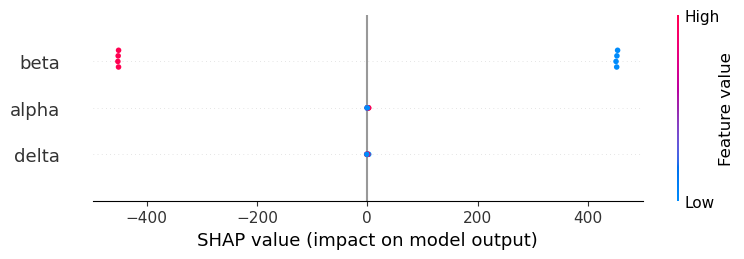

In [52]:
import os
import pyciemss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

start_time = 0.0
end_time = 20
logging_step_size = 10.0
num_samples = 20

# Define the simulation function
def sim(inputs, focus='S_state'):
    results = []
    for input_row in inputs:
        alpha, beta, delta = input_row
        
        # Define the intervention
        intervention = {
            torch.tensor(start_time): {
                "p_cbeta": torch.tensor(beta)
            }
        }
        
        # Run the simulation with the intervention
        result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time,
                                 static_parameter_interventions=intervention)
        
        # Get the median value of the focus variable
        median_value = np.median(result["data"][focus]) if not result["data"].empty else np.nan
        results.append(median_value)
    return np.array(results)

# Generate plausible random/step values for inputs (start small)
alpha_values = np.linspace(0, 1.0, 2)
beta_values = np.linspace(0, 1.0, 2)
delta_values = np.linspace(0, 1.0, 2)

# Create input combinations
inputs = np.array(list(product(alpha_values, beta_values, delta_values)))

# Use SHAP to explain the model with the sim function
explainer = shap.Explainer(sim, inputs)
shap_values = explainer(inputs)

# Plot SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, feature_names=["alpha", "beta", "delta"])
plt.show()


In [ ]:
import os
import pyciemss
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 10

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].tail())


# Define the simulation function
def sim(inputs, focus='hospitalized_observable_state'):
    results = []
    for input_row in inputs:
        alpha, beta, delta = input_row
        
        # Define the intervention
        intervention = {
            torch.tensor(start_time): {
                "p_cbeta": torch.tensor(beta)
            }
        }
        
        # Run the simulation with the intervention
        result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time,
                                 static_parameter_interventions=intervention)
        
        # Get the median value of the focus variable
        median_value = np.median(result["data"][focus]) if not result["data"].empty else np.nan
        results.append(median_value)
    return np.array(results)

# Generate plausible random/step values for inputs (start small)
alpha_values = np.linspace(0.1, 1.0, 10)
beta_values = np.linspace(0.1, 1.0, 10)
delta_values = np.linspace(0.1, 1.0, 10)

# Create input combinations
inputs = np.array(list(product(alpha_values, beta_values, delta_values)))

# Use SHAP to explain the model with the sim function
explainer = shap.Explainer(sim, inputs)
shap_values = explainer(inputs)

# Plot SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, feature_names=["alpha", "beta", "delta"])
plt.show()
